In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime
import ast

import json
import os
from dotenv import load_dotenv #pip install python-dotenv

from bs4 import BeautifulSoup
import requests 

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

In [3]:
df_lengths_0 = pd.read_csv('Datasets/df_lengths_0.csv')
df_lengths_0.shape

(226, 3)

### **Discogs API**

I have to define again the function, because I have dropped the ``master_id`` column

In [5]:
def get_lengths_discogs(df):
    # create empty lists
    artists_list = []
    titles_list = []
    lengths_list = []
    count = 0
    scraped = 0

    # Function to calculate album length from tracklist durations
    def get_album_length(tracklist):
        song_durations = []
        for track in tracklist:
            try:
                song_duration = track['duration']
                minutes, seconds = map(int, song_duration.split(':'))
                song_duration_minutes = minutes + seconds / 60
                song_durations.append(song_duration_minutes)
            except Exception as e:
                pass
        return round(sum(song_durations), 2)

    for artist, title in df[['artist', 'title']].values:                         
        count += 1
        time.sleep(1)
        artists_list.append(artist)
        titles_list.append(title)
        query = artist + ' ' + title

        # Define API headers
        headers = {
            "User-Agent": 'Arnau', 
            "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"
        }

        # Set the API URL and params
        url = "https://api.discogs.com/database/search"
        params = {
            "per_page": 100,  # Number of results per page (max 100)
            'type': 'release',
            'format': 'album',
            'genre': 'Rock',
            'query': query
        }

        # Request the data from Discogs
        response = requests.get(url, headers=headers, params=params)
        data = response.json()

        # Store lengths for the album
        album_lengths = []

        # Iterate over the first 5 results
        for i in range(min(5, len(data['results']))):
            time.sleep(1)
            release_id = data['results'][i]['id']
            url2 = f"https://api.discogs.com/releases/{release_id}"
            response = requests.get(url2, headers=headers)
            data2 = response.json()

            try:
                tracklist = data2['tracklist']
                album_length = get_album_length(tracklist)
                if album_length > 0:
                    album_lengths.append(album_length)
            except KeyError:
                print(f"Tracklist not found for release {release_id}")
                continue

        # Choose a length for the album
        if album_lengths:
            average_length = round(sum(album_lengths) / len(album_lengths), 2)
            lengths_list.append(average_length)
            scraped+=1
        else:
            lengths_list.append(0)

        print(f"{scraped}/{count}: {artist} - {title}")
        
        # Create a DataFrame with the results
        df_lengths_found = pd.DataFrame({'artist': artists_list,
                                        'title': titles_list,
                                        'album_length': lengths_list})

    # I decided to export the csv inside the function because of the limitations of the Discogs API,
    # while trying I some code crashed in the middle, having lost time and data,
    # so I prefer the code to be slower but have the data exported at every new album scraped. 
        df_lengths_found.to_csv('Datasets/df_lengths_found_discogs.csv', index=False)

In [6]:
df_lengths_found = get_lengths_discogs(df_lengths_0)

1/1: PIG - Praise The Lard
2/2: Weekend - Sports
3/3: Tank - Honour And Blood
3/4: Sebadoh - Weed Forestin
3/5: Rich Kids on LSD - Keep Laughing
4/6: Druid - Toward the Sun
5/7: Nucleus (UK) - We'll Talk About It Later
5/8: Miasma and The Carousel of Headless Horses - Perils
6/9: Comus - To Keep From Crying
7/10: Blitzkrieg - A Time Of Changes
7/11: DOOM - War Crimes (Inhuman Beings)
7/12: Iron Maiden - Visions Of The Beast
7/13: Gasp - Drome Triler of Puzzle Zoo People
8/14: Treepeople - Guilt Regret Embarrassment
9/15: Current 93 - Christ and the Pale Queens Mighty in Sorrow
10/16: The Jimi Hendrix Experience - Are You Experienced
10/17: Kaleidoscope - Tangerine Dream
11/18: I Hate Myself - 10 Songs
12/19: Extreme Noise Terror - Retro-bution
13/20: Rich Kids on LSD - Riches to Rags
14/21: Omen - The Curse
15/22: The Nation of Ulysses - 13-Point Program To Destroy America
16/23: Gentle Giant - The Power and the Glory
17/24: Sweep the Leg Johnny - Going Down Swingin'
17/25: Lifetime - 

In [2]:
# comprovar quantes requests he fet i quantes me'n queden

url_search = "https://api.discogs.com/database/search"

params = {
    "type": "release"  # Search for masters
}

headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url_search, headers=headers, params=params)

rate_limit = response.headers.get("X-Discogs-Ratelimit")
rate_limit_used = response.headers.get("X-Discogs-Ratelimit-Used")
rate_limit_remaining = response.headers.get("X-Discogs-Ratelimit-Remaining")

print(f"Rate Limit: {rate_limit}")
print(f"Rate Limit Used: {rate_limit_used}")
print(f"Rate Limit Remaining: {rate_limit_remaining}")

Rate Limit: 60
Rate Limit Used: 0
Rate Limit Remaining: 60


### **Proves**: per veure els items en certs years/styles

In [124]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# genres = ["Blues", "Classical", "Electronic", "Folk, World, & Country", "Funk / Soul", "Hip-Hop", "Jazz", "Latin", "Pop", "Rock", "Stage & Screen"]
# rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
#               , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

for year in range(1993, 2003):
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'US'
        , 'year': year
        # , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{year}: {items_number}")

1993: 7922
1994: 9949
1995: 10660
1996: 10614
1997: 10571
1998: 10847
1999: 11338
2000: 11206
2001: 11045
2002: 11442


In [31]:
# get one style in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100    # Number of results per page (max 100)
    , 'type': 'release'
    , 'format': 'album'
    , 'page': 1

    # items to change
    , 'country': 'US'
    , 'year': 1968
    , 'genre': 'Rock'
    # , 'style': 'Prog Rock'
}

response = requests.get(url, headers=headers, params=params)
data = response.json()
items_number = response.json()['pagination']['items']  # number of items

print(f"Items: {items_number}")

# response.json()

Items: 4331


### **defining the function** to get all albums, including where ``master_id = 0``

In [2]:
artists_to_remove = ['Cemetery Skyline', 'Goat', 'Kingcrow', 'Speed', 'Hyperdontia', 'Vredehammer', 'Weston Super Maim',
                    'Mdou Moctar', 'AVRALIZE', 'Engulfed', 'Coffin Storm', 'samlrc', 'Little Kid', 'Termina', 'Rorcal',
                    'Reverence To Paroxysm', 'Voyager', 'Blindfolded and Led to the Woods', 'Mork', 'Yeule', 'Pond',
                    'Empire State Bastard', 'Blood Command', 'Avatar', 'Brutus', 'Faceless Burial', 'Within Destruction',
                    'Sedimentum', 'Ataraxy', 'Corpsessed', 'Epitaphe', 'Aldous Harding', 'Messa', 'Ghost', 'Ecchymosis',
                    'Wormrot', 'Vertebra Atlantis', 'Papangu', 'Sermon of Flames', 'Springtime', 'Monolord', 'Sulphurous',
                    'LLNN', 'Trna', 'Slaughter To Prevail', 'sonhos tomam conta', 'Galvanizer', 'Ophidian I', 'Diabolizer',
                    'Morbific', 'Defacement', 'Divide And Dissolve', 'Soen', 'Scorpions', 'Accept', 'Respire', 'Undergang',
                    'Bearings', 'Scalp', 'Miasmatic Necrosis', 'Teenage Mutant Ninja Turtles', 'Gorephilia', 'Vous Autres',
                    'Carnation', 'Pharmacist', 'Paara', "Justice For The Damned", 'VVilderness', 'Molested Divinity', 'Ellis',
                     'Kontinuum', 'Monsters', 'Giver', 'Lowrider', 'Vengeful Spectre', 'Vomit the Soul', 'Sadisme', 'Alarmist',
                     'Klone', 'Nocturnal Departure', 'King Gizzard and The Lizard Wizard', 'Make Them Suffer', 'The Chats',
                     'Patrick Watson', 'Shirokuma', 'Forests', 'Town Portal', 'Ceremony Of Silence', 'CHAI', 'Baalsebub',
                     'Minors', 'Mono', 'Tallies', 'Normandie', 'Mouse On The Keys', 'Burial Invocation', 'Orville Peck',
                     'Lunatic Soul', 'Alex Lahey', 'Hozier', 'Mystifier', 'Hands Like Houses', 'Ruins', 'Autokrator',
                     'Legend of the Seagullmen', 'Death Toll 80k', 'IDYLLS', 'Spaceslug', 'i hate sex', 'Band-Maid',
                     'With the Dead', 'Hungry Ghosts', 'Middle Kids', 'Gleb Kolyadin', "Leaves' Eyes", "Phrenelith",
                     "David Brent", "Art Of Dying", "Minor Victories", "Pantha Du Prince", "Schammasch", 'LUH',
                     'Violet Cold', 'EL VY', 'Shining', 'Hills', "Mutiny On The Bounty", 'Lucifer', 'FFS', 'Ranger',
                     'Trepalium', 'A Textbook Tragedy', 'This Is A Standoff', 'FACT', 'Swallowed', 'Disembarked',
                     'Wildbirds and Peacedrums', 'Archivist', 'Timber Timbre', 'Newsboys', 'Dope Lemon', 'Vagabon',
                     'RY X', 'Moonlit Sailor', 'The Drones', 'Sarah Neufeld', 'Say Lou Lou', 'Cruciamentum', 'Lay Down Rotten',
                     'Dreamshade', 'Sickening Gore', 'Circles', "Avey Tare's Slasher Flicks", 'Forest Silence',
                     "One Eyed God Prophecy", 'Coffins', 'Osamu Kitajima', 'Living With Lions', 'Ansur', 'Parades',
                     "Intestine Baalism", 'Comity', 'No Omega', 'Wolverine', 'Disavowed', 'Angel Dust', "!T.O.O.H.!",
                     'Hypnosia', 'Hexenhaus', 'Paradox', 'Deathrow', 'Excruciate', 'FareWell Poetry', 'Sights and Sounds',
                     'Supersister', "Birds Of Tokyo", 'Ark', "The Flower Kings", 'Beardfish', 'Graveworm', 'Acid',
                     'Ladyhawke', 'Geddy Lee', 'Yngwie Malmsteen', "World's End Girlfriend", 'Totem Skin', 'Lewis',
                     'I Hate Sally', "The Band", 'Lisa Hannigan', 'Lethal', 'Bubu', 'Van She', 'Mooncake', 'The Haunted',
                     "Orphaned Land", 'Madder Mortem', 'Kataxu', 'Gilberto Gil', 'Vendetta', 'Kvist', 'Acrostichon', 'Pain',
                     'Obliteration', 'Flames of Hell', 'Wombbath', 'Stone', 'Disgrace', 'Fionn Regan', 'Disastrous Murmur',
                     'Urfaust', 'Sleepingdog', 'Island', 'Bethlehem', 'Subterranean Masquerade', 'After Dinner', 
                     'Black Boned Angel', 'FM', 'Embrace', 'Solefald', 'Maneige', 'Amberian Dawn', 'OOIOO', 'Anekdoten',
                     "Aphrodite's Child", 'Hollenthon', 'Lykke Li', 'Lenka', 'Sarah McLachlan', 'Owen Pallett',
                     'Devin Townsend Project', 'Missy Higgins', 'The Devin Townsend Band', 'Selda', 'Massacra', "Rory Gallagher",
                     'Taste', 'Celestial Season', 'Ida Maria', 'Dark Tranquillity', 'Cadaver', 'Pele', 'Exuma',
                     'Great Lake Swimmers', 'Dawn', 'The Bats', 'Yoko Ono', 'Illogicist', 'The Saints', 'Final Fantasy',
                     'Pendulum', 'Lunar Aurora', 'Bee Gees', 'Stars', "David Sylvian and Robert Fripp", 'Afflicted', 'Lengsel',
                     'Extol', 'MDFMK', 'Univers Zero', 'Mortuary Drape', 'Zyklon', 'Winds', 'Zyklon-B', 'The Sins of Thy Beloved',
                     'Lords of Acid', 'Devin Townsend', 'Diablo Swing Orchestra', 'Arcturus', 'Cornelius', 'Manu Chao',
                     'Bryan Adams', 'Peaches', 'Doro', 'Kingdom Come', 'Pekka Pohjola', 'Shakira', 'Massacre', 'Subhumans',
                     'Set Fire to Flames', 'Gorgoroth', 'Gandalf', 'Klaus Schulze', 'The Ecstasy of Saint Theresa',
                     "Lou Reed and John Cale", 'Brian Eno and David Byrne', 'Bob Dylan and The Band', 'Era', 'Devil Doll']

In [3]:
def get_masters_us(start_year, final_year, step):
    url_search = "https://api.discogs.com/database/search"
    headers = {"User-Agent": "MyDiscogsApp", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

    # import the df that contains all the albums already scraped (mosty from the UK)
    df_uk_masters = pd.read_csv('Datasets/df_uk_masters.csv')

    # import the df that contains all the albums already scraped and cleaned (mosty from the UK)
    df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')

    # import the df of the albums from the US scraped so far (until 2000)
    df_us_masters = pd.read_csv('Datasets/df_us_masters.csv')

    # import the df of the albums from the US scraped so far (from 2000)
    df_us_new_masters = pd.read_csv('Datasets/df_us_new_masters.csv')

    styles_to_get = [
        "Alternative Rock", "Indie Rock", "Pop Rock", "New Wave", 
        "Emo", "Post Rock", "Shoegaze", "Indie Pop", "Hard Rock", 
        "Heavy Metal", "Death Metal", "Thrash", "Black Metal", "Doom Metal", 
        "Metalcore", "Progressive Metal", "Stoner Rock", "Speed Metal", "Nu Metal", 
        "Prog Rock", "Psychedelic Rock", "Art Rock", "Classic Rock", "Space Rock", 
        "Symphonic Rock", "Punk", "Hardcore", "Post-Punk", "Post-Hardcore", 
        "Pop Punk", "Grunge", "Garage Rock", "Folk Rock", "Blues Rock", "Rock & Roll", 
        "Soft Rock", "Country Rock", "Southern Rock"
    ]

    # create empty lists
    artist_id_list = []
    artists_list = []
    titles_list = []
    years_list = []
    release_countries_list = []
    album_length_list = []
    tracks_list = []
    release_type_list = []
    genres_list = []
    styles_list = []
    master_id_new_list = []
    artist_profile_list = []
    main_release_id_list = []

    attempts = 0
    scraped = 0

    for year in range(start_year, final_year, step):
        for style in styles_to_get:
            print(f'{style} releases of {year}')

            # Define parameters for album search
            params = {
                "type": "release"  # Search for masters
                , "format": "album"           # just search for albums
                , "per_page": 100    # Number of results per page (max 100)
                , "page": 1          # Start with page 1
                , 'country': 'US'
                , "year": year
                , 'genre': 'Rock'
                , 'style': style
            }

            response1 = requests.get(url_search, headers=headers, params=params)
            time.sleep(1)
            data1 = response1.json()

            items = data1['pagination']['items']
            print(f'Items: {items} {style} releases')

            pages = data1['pagination']['pages']+1
            
            for page in range(1, pages):
                print(f'------------ Page: {page} of {pages-1}, {style} of {year} -------------')

                params['page'] = page     # change pages
                response2 = requests.get(url_search, headers=headers, params=params)
                data2 = response2.json()

                for id in range(len(data2['results'])):
                    try:
                        attempts+=1
                        time.sleep(1)
                        master_id = data2['results'][id]['master_id']
                        release_id = data2['results'][id]['id']

                        if master_id == 0:
                            print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id}')

                            url_release = f"https://api.discogs.com/releases/{release_id}"
                            response3 = requests.get(url_release, headers=headers)
                            # time.sleep(1)
                            data3 = response3.json()
                            artist = data3['artists'][0]['name']
                            title = data3['title']

                            if ((df_uk_masters['artist'] == artist) & (df_uk_masters['title'] == title)).any() or \
                                ((df_us_masters['artist'] == artist) & (df_us_masters['title'] == title)).any() or \
                                ((df_masters_blended['artist'] == artist) & (df_masters_blended['title'] == title)).any() or \
                                ((df_us_new_masters['artist'] == artist) & (df_us_new_masters['title'] == title)).any():
                                print(f"Album already scraped: {artist} - {title}")
                                continue

                            elif artist in artists_to_remove:
                                continue

                            elif (artist, title) in zip(artists_list, titles_list):
                                print(f"Album already scraped right now: {artist} - {title}") 
                                continue        

                            else:
                                try:
                                    if artist == 'Various':
                                            print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: Compilation') 
                                            continue   # I don't want compilations
                                    else:
                                    # define the data I want to get
                                        release_year = data3['year']                
                                        genres = data3['genres']
                                        styles = data3['styles']
                                        if 'Rock' not in genres:
                                            print('Not a rock album. Skipping')
                                            continue    # I only want rock albums

                                    # a more complex information is the total duration of the album, I have to sum the durations of each song
                                        number_of_songs = len(data3['tracklist'])
                                        song_durations = []

                                        for song in range(number_of_songs):
                                            song_duration = data3['tracklist'][song]['duration']
                                            try:
                                                minutes, seconds = map(int, song_duration.split(':'))
                                                song_duration_minutes = minutes + seconds/60
                                                song_durations.append(song_duration_minutes)
                                            except:
                                                pass
                                            album_length = round(sum(song_durations), 2)

                                        artist_id = data3['artists'][0]['id']

                                    # define the data I want to get
                                        release_country = data3['country']
                                        release_type = data3['formats'][0]['descriptions']
                                        if 'Compilation' in release_type:
                                            print('Compilation detected. Skipping')
                                            continue    # pass to the next album, I don't want compilations

                                    # artist page
                                        url = f"https://api.discogs.com/artists/{artist_id}"
                                        time.sleep(1)
                                        response5 = requests.get(url, headers=headers)
                                        data5 = response5.json()

                                    # define the data I want to get
                                        try:
                                            artist_profile = data5['profile']
                                        except:
                                            artist_profile = np.nan
                                            pass

                                    # save the info in the lists
                                        artist_id_list.append(str(artist_id))
                                        artists_list.append(artist)
                                        titles_list.append(title)
                                        years_list.append(release_year)
                                        genres_list.append(genres)
                                        styles_list.append(styles)
                                        master_id_new_list.append(0)
                                        album_length_list.append(album_length)
                                        tracks_list.append(number_of_songs)
                                        release_countries_list.append(release_country)
                                        release_type_list.append(release_type)
                                        main_release_id_list.append(release_id)

                                        if artist_profile == '':
                                            artist_profile_list.append(np.nan)
                                        else:
                                            artist_profile_list.append(artist_profile)

                                        scraped+=1

                                    # list lengths
                                        lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                                , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                                    # Check if all lists have the same length
                                        lengths = [len(lst) for lst in lists]
                                        if len(set(lengths)) != 1:
                                            print("Lengths are not the same.")
                                            break # stop the loop, I won't be able to store the data if I have one value missing

                                        print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: {artist} - {title}')
                                except:
                                    print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: {artist} - {title} - Album not found')
                                    continue    # sometimes it crashes for some unknown reason, so I skip this album and continue
                        
                        # if it's an album that I have already scraped in this current code
                        elif master_id in master_id_new_list:
                            print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already in list') 
                            continue        # there are several releases of the same master_release, I just want one (the master_release)

                        elif (master_id in df_uk_masters['master_id'].values) or \
                            (master_id in df_masters_blended['master_id'].values):
                            print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already scraped from the UK')
                            continue        # I have already scraped it before

                        elif (master_id in df_us_masters['master_id'].values) or \
                            (master_id in df_us_new_masters['master_id'].values):
                            print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already scraped from the USA')
                            continue        # I have already scraped it before

                        else:
                            url_master = f"https://api.discogs.com/masters/{master_id}"
                            response3 = requests.get(url_master, headers=headers)
                            time.sleep(1)
                            data3 = response3.json()

                            artist = data3['artists'][0]['name']

                            if artist == 'Various':
                                    print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: Compilation') 
                                    continue   # I don't want compilations
                            
                            elif artist in artists_to_remove:
                                continue

                            else:
                            # define the data I want to get
                                title = data3['title']
                                release_year = data3['year']                 
                                genres = data3['genres']
                                styles = data3['styles']
                                if 'Rock' not in genres:
                                    print('Not a rock album. Skipping')
                                    continue    # I only want rock albums
                                
                            # a more complex information is the total duration of the album, I have to sum the durations of each song
                                number_of_songs = len(data3['tracklist'])
                                song_durations = []

                                for song in range(number_of_songs):
                                    song_duration = data3['tracklist'][song]['duration']
                                    try:
                                        minutes = int(song_duration.split(':')[0])
                                        seconds = int(song_duration.split(':')[1])
                                        song_duration_minutes = minutes + seconds/60
                                        song_durations.append(song_duration_minutes)
                                    except:
                                        pass
                                    album_length = round(sum(i for i in song_durations), 2)

                                main_release_id = data3['main_release']
                                artist_id = data3['artists'][0]['id']

                            # release page
                                url = f"https://api.discogs.com/releases/{main_release_id}"
                                # time.sleep(1)
                                response4 = requests.get(url, headers=headers)
                                data4 = response4.json()

                            # define the data I want to get
                                release_country = data4['country']
                                release_type = data4['formats'][0]['descriptions']
                                if 'Compilation' in release_type:
                                    print('Compilation detected. Skipping')
                                    continue    # pass to the next album, I don't want compilations

                            # artist page
                                url = f"https://api.discogs.com/artists/{artist_id}"
                                # time.sleep(1)
                                response5 = requests.get(url, headers=headers)
                                data5 = response5.json()

                            # define the data I want to get
                                try:
                                    artist_profile = data5['profile']
                                except:
                                    artist_profile = np.nan
                                    pass

                            # save the info in the lists
                                artist_id_list.append(str(artist_id))
                                artists_list.append(artist)
                                titles_list.append(title)
                                years_list.append(release_year)
                                genres_list.append(genres)
                                styles_list.append(styles)
                                master_id_new_list.append(master_id)
                                album_length_list.append(album_length)
                                tracks_list.append(number_of_songs)
                                release_countries_list.append(release_country)
                                release_type_list.append(release_type)
                                main_release_id_list.append(main_release_id)

                                if artist_profile == '':
                                    artist_profile_list.append(np.nan)
                                else:
                                    artist_profile_list.append(artist_profile)

                                scraped+=1

                            # list lengths
                                lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                        , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                            # Check if all lists have the same length
                                lengths = [len(lst) for lst in lists]
                                if len(set(lengths)) != 1:
                                    print("Lengths are not the same.")
                                    break # stop the loop, I won't be able to store the data if I have one value missing

                                print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: {artist} - {title}')
                                # time.sleep(1)

                            # save the data in a df and export it
                                data = pd.DataFrame({'artist_id': artist_id_list
                                , 'master_id': master_id_new_list
                                , 'main_release_id': main_release_id_list
                                , 'release_country': release_countries_list
                                , 'artist': artists_list
                                , 'title': titles_list
                                , 'year': years_list
                                , 'album_length': album_length_list
                                , 'tracks': tracks_list
                                , 'release_type': release_type_list
                                , 'genres': genres_list
                                , 'styles': styles_list
                                , 'artist_profile': artist_profile_list})

                    except:
                        print('Strange error')
                        continue    # sometimes it crashes for some unknown reason, so I skip this album and continue

            # export a df for every year everytime I finish a style
                data.to_csv(f'Datasets/df_us_{year}.csv', index=False)

### **Actual code to get all albums**

**What to Drop? (Even for the 60s–2020s range)**

These styles aren’t really rock in any decade:

❌ Easy Listening, New Age, Free Improvisation, Abstract, Rhythm & Blues, Doo Wop, Soul, Bluegrass, Vocal, Ballad, Jazz-Funk, Disco, Funk

Why? They either:
- Weren’t major parts of the rock genre (Disco, Funk, Soul, R&B, etc.).
- Were independent movements that didn't blend much with rock (New Age, Easy Listening, Jazz-Funk).

In [ ]:
styles_to_get = [
    "Alternative Rock", "Indie Rock", "Pop Rock", "New Wave", 
    "Emo", "Post Rock", "Shoegaze", "Hard Rock", 
    "Heavy Metal", "Death Metal", "Thrash", "Black Metal", "Doom Metal", 
    "Metalcore", "Progressive Metal", "Stoner Rock", "Speed Metal", "Nu Metal", 
    "Prog Rock", "Psychedelic Rock", "Art Rock", "Classic Rock", "Space Rock", 
    "Symphonic Rock", "Punk", "Hardcore", "Post-Punk", "Post-Hardcore", 
    "Pop Punk", "Grunge", "Garage Rock", "Folk Rock", "Blues Rock", "Rock & Roll", 
    "Soft Rock", "Country Rock", "Southern Rock"
]

In [21]:
# import the df of the albums from the US scraped so far (from 1960)
df_us_new_masters = pd.read_csv('Datasets/df_us_new_masters.csv')
df_us_new_masters.shape

(52399, 13)

<Axes: xlabel='count', ylabel='year'>

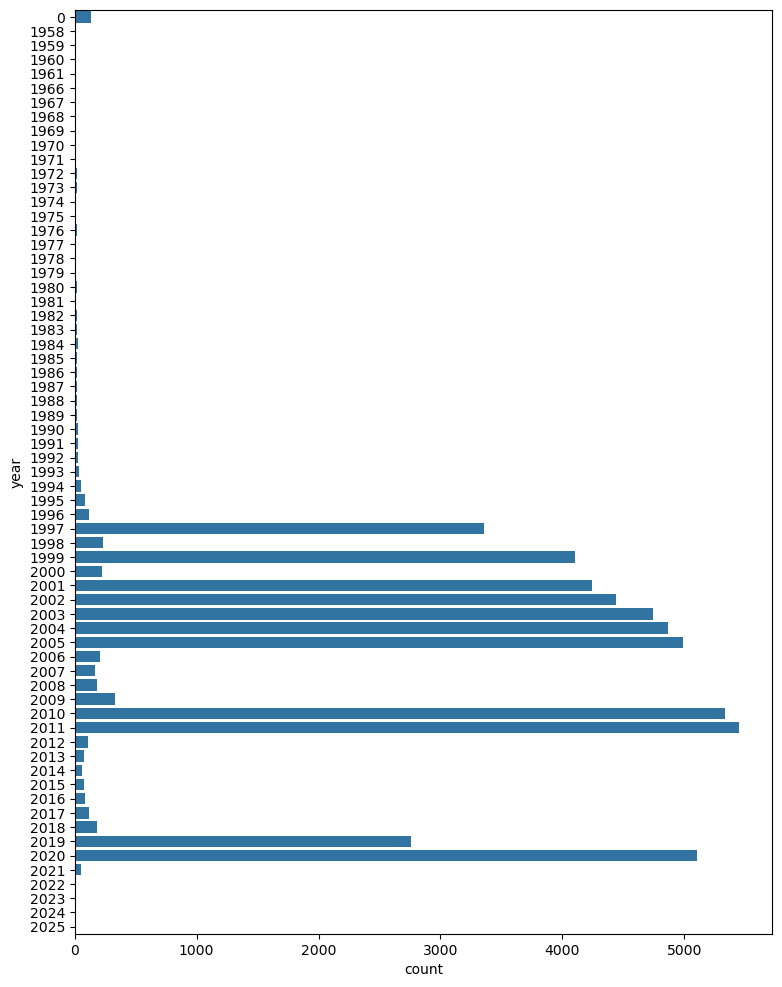

In [22]:
# make sure most of the albums are from the year I theoretically just got
plt.figure(figsize=(9,12))
sns.countplot(data=df_us_new_masters, y='year')

In [23]:
get_masters_us(2006, 2008, 1)

Alternative Rock releases of 2006
Items: 1807 Alternative Rock releases
------------ Page: 1 of 19, Alternative Rock of 2006 -------------
1 attempts - 0 scraped - 1/1807 - master_id 0
1 attempts - 1 scraped - 1/1807 - release_id 28611496: Thunderbirds Are Now! - Spaceland Presents:Thunderbirds Are Now! In Spaceland 10/14/06
2 attempts - 1 scraped - 2/1807 - master_id 219309 already scraped from the UK
3 attempts - 1 scraped - 3/1807 - master_id 157375 already scraped from the UK
4 attempts - 1 scraped - 4/1807 - master_id 0
4 attempts - 2 scraped - 4/1807 - release_id 3297571: Debra Arlyn - Complicated Mess
5 attempts - 2 scraped - 5/1807 - master_id 0
5 attempts - 3 scraped - 5/1807 - release_id 1864966: Expo '70 - Live 090805
6 attempts - 4 scraped - 6/1807 - master_id 1430762: Last Conservative - Pretty New Things
7 attempts - 4 scraped - 7/1807 - master_id 159068 already scraped from the UK
8 attempts - 5 scraped - 8/1807 - master_id 498228: Rich Hopkins & Luminarios - The Horse I

In [24]:
minutes = 1122
attempts = 39159 

seconds_per_attempt = minutes*60/attempts
seconds_per_attempt 

1.7191450241323833

Aprox 1.60 seconds per album

### **Importing the data**

Since the information in the lists exist only inside the function, I had to create the df and export it in order to save the information, so now I have to import it again.

In [25]:
data = pd.read_csv('Datasets/df_us_2007.csv')
print(f'Year: 2007 \n{data.shape[0]} releases\n{data.artist.nunique()} different artists\n')

Year: 2007 
11401 releases
10384 different artists



In [26]:
data.sample(5)

artist_id  master_id  main_release_id release_country  \
5278   4452825.0          0         12871456              US   
8056   7155773.0          0         13628351              US   
10554  4515711.0          0          7394407              US   
470    6260439.0          0         11455733              US   
2455   6476312.0          0         12140740              US   

                  artist                         title  year  album_length  \
5278         The Loomers                Tomorrow Today  2006           0.0   
8056             Anj (3)             When Grey Blushes  2007           0.0   
10554  The Alliance (14)                     Hit Em Up  2007           0.0   
470         Antiques (7)  Forgotten People Tread Water  2006           0.0   
2455     Allies In Chaos                  Pray America  2006           0.0   

       tracks release_type           genres  \
5278       16    ['Album']  ['Rock', 'Pop']   
8056       12    ['Album']  ['Rock', 'Pop']   
10554      13    ['Album']         ['Rock']   
470        13    ['Album']         ['Rock']   
2455        9    ['Album']         ['Rock']   

                                          styles  \
5278   ['Country Rock', 'Folk Rock', 'Pop Rock']   
8056                     ['Indie Pop', 'Ballad']   
10554                               ['Hardcore']   
470           ['Indie Rock', 'Alternative Rock']   
2455                               ['Hard Rock']   

                                          artist_profile  
5278                                                 NaN  
8056                                                 NaN  
10554  Hardcore band from Detroit, Michigan/Windsor, ...  
470                                                  NaN  
2455                                                 NaN

In [27]:
data.styles.value_counts().head(10)

styles
['Indie Rock']                        706
['Alternative Rock']                  548
['Punk']                              421
['Hard Rock']                         247
['Pop Rock']                          226
['Hardcore']                          221
['Black Metal']                       215
['Death Metal']                       199
['Heavy Metal']                       197
['Alternative Rock', 'Indie Rock']    164
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='year'>

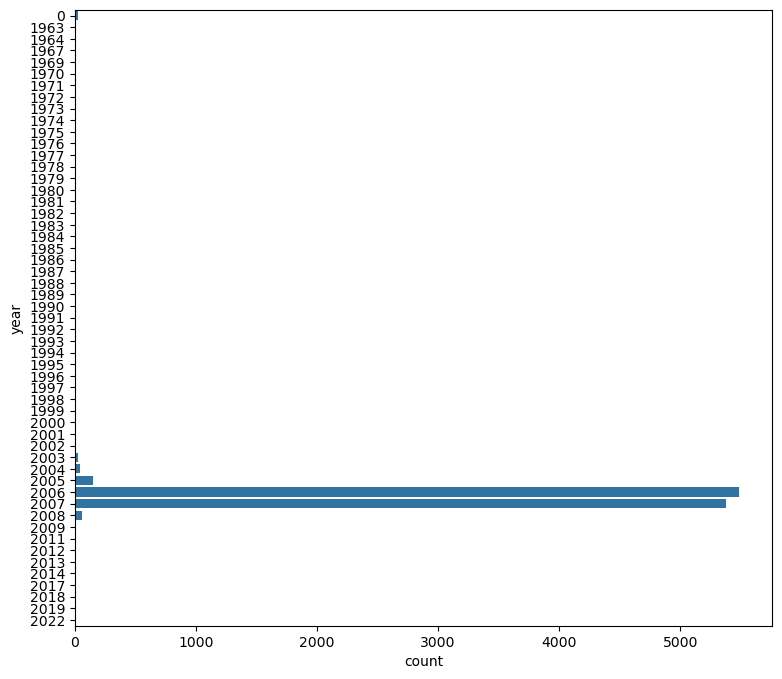

In [28]:
# make sure most of the albums are from the year I theoretically just got
plt.figure(figsize=(9,8))
sns.countplot(data=data, y='year')

### **Look for duplicates**

**Exact duplicates I can get rid of**

In [29]:
data[data.duplicated()].shape

(0, 13)

In [ ]:
print(f"Rows before dropping: {data.shape[0]}")
data.drop_duplicates(inplace=True)
print(f"Rows after dropping: {data.shape[0]}")

(193, 13)

**Duplicates by some features, but not for ``master_id``, probably one ``master_id = 0``**

In [30]:
data.sort_values('master_id', inplace=True, ascending=False) # so I keep the master_id=0 at the end, these would be the duplicates and I'll be able to drop them
data.reset_index(drop=True, inplace=True)
data[data[['artist', 'title', 'year', 'album_length', 'tracks']].duplicated()].shape

(11, 13)

In [32]:
print(f"Rows before dropping: {data.shape[0]}")
data.drop_duplicates(subset=(['artist', 'title', 'year', 'album_length', 'tracks']), inplace=True)
print(f"Rows after dropping: {data.shape[0]}")

Rows before dropping: 11401
Rows after dropping: 11390


#### Change the dtype of ``artist_id`` (if possible)

In [30]:
data[data['artist_id'].isna()]

artist_id  master_id  main_release_id release_country  \
525        NaN          0          5312287              US   
547        NaN          0          6762254              US   

                   artist                  title  year  album_length  tracks  \
525        Guess Who, The  Live At The Paramount  1972         46.02       7   
547  Dave Lamb & Gye Whiz        I'll Be Alright  1971         32.35       8   

        release_type    genres                             styles  \
525  ['Album', 'LP']  ['Rock']                   ['Classic Rock']   
547  ['LP', 'Album']  ['Rock']  ['Folk Rock', 'Psychedelic Rock']   

    artist_profile  
525            NaN  
547            NaN

In [31]:
data[data['artist']=='Dave Lamb & Gye Whiz']

artist_id  master_id  main_release_id release_country  \
547        NaN          0          6762254              US   

                   artist            title  year  album_length  tracks  \
547  Dave Lamb & Gye Whiz  I'll Be Alright  1971         32.35       8   

        release_type    genres                             styles  \
547  ['LP', 'Album']  ['Rock']  ['Folk Rock', 'Psychedelic Rock']   

    artist_profile  
547            NaN

In [ ]:
data.loc[7046, 'artist_id'] = 32990

In [ ]:
data['artist_id'] = data['artist_id'].astype(int)
data.head()

### **Concat with the df that contains the albums previously scrapped**

In [33]:
# import the last df
df_masters = pd.read_csv('Datasets/df_us_new_masters.csv')
df_masters.shape

(52399, 13)

In [34]:
# concat with the df of the albums I just scraped
df_masters_concat = pd.concat([df_masters, data])
df_masters_concat.reset_index(drop=True, inplace=True)
df_masters_concat.shape

(63789, 13)

In [36]:
check_duplicates(df_masters_concat)

No duplicates


In [37]:
print(f'{df_masters_concat.shape[0]} releases\n{df_masters_concat.artist.nunique()} different artists')

63789 releases
46044 different artists


### **Exporting to csv**

In [38]:
df_masters_concat.to_csv('Datasets/df_us_new_masters.csv', index=False)

### **Statistics**

In [39]:
# import the last df
df_masters = pd.read_csv('Datasets/df_us_new_masters.csv')
df_masters.shape

(63789, 13)

<Axes: xlabel='count', ylabel='year'>

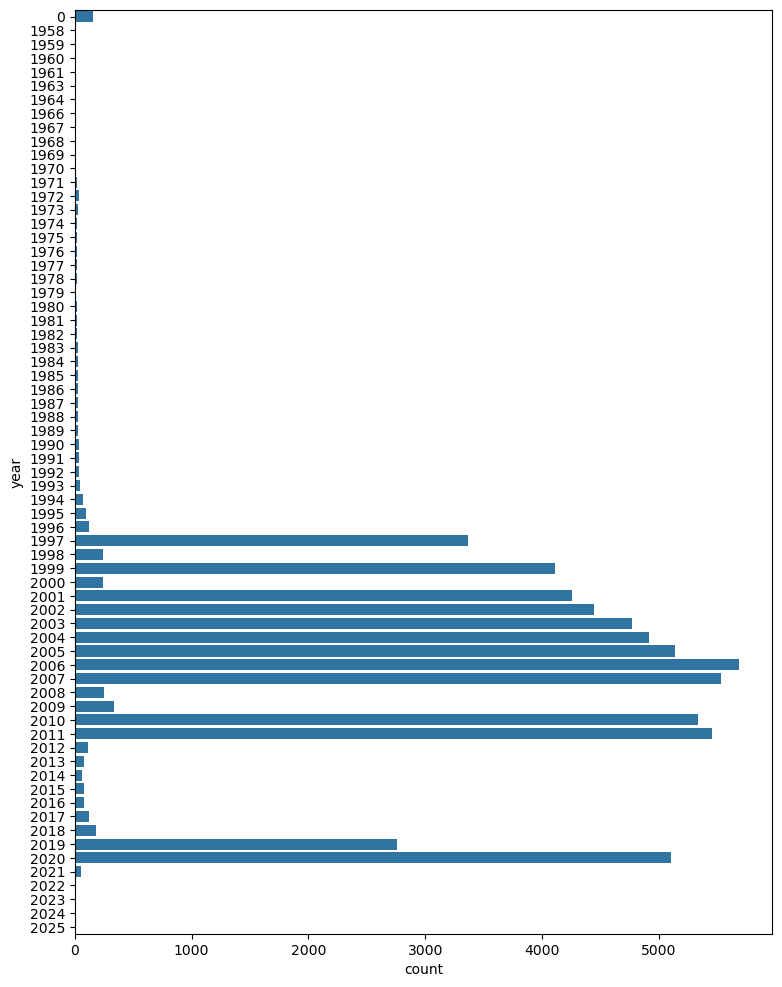

In [40]:
plt.figure(figsize=(9,12))
sns.countplot(data=df_masters, y='year')

In [28]:
df_masters.release_country.value_counts().head(10)

release_country
US              29146
Europe            694
Germany           529
Japan             177
Canada            172
UK                127
Sweden            120
USA & Canada      110
Australia         106
France            105
Name: count, dtype: int64

In [29]:
df_masters.artist.value_counts().head(10)

artist
Pearl Jam                     131
R. Stevie Moore                68
The Grateful Dead              33
The String Cheese Incident     30
The Allman Brothers Band       28
Buckethead                     26
Phish                          25
Cloud Nothings                 21
RJ.JR                          21
Dream Theater                  18
Name: count, dtype: int64

In [30]:
df_masters.genres.value_counts().head()

genres
['Rock']                              23450
['Rock', 'Pop']                        1933
['Electronic', 'Rock']                 1786
['Rock', 'Folk, World, & Country']     1620
['Rock', 'Blues']                       479
Name: count, dtype: int64

In [31]:
df_masters.styles.value_counts().head(10)

styles
['Indie Rock']                        1649
['Alternative Rock']                  1418
['Punk']                              1299
['Nu Metal']                           594
['Death Metal']                        590
['Hard Rock']                          580
['Pop Rock']                           502
['Heavy Metal']                        498
['Hardcore']                           494
['Alternative Rock', 'Indie Rock']     404
Name: count, dtype: int64

In [116]:
df_masters[df_masters['release_country']=='Europe'].sort_values('artist')

artist_id  master_id  main_release_id release_country  \
20683   293116.0     383760          1950750          Europe   
20572   155937.0     415194          3446518          Europe   
20302   966302.0     496822          3473810          Europe   
17548   255970.0     153008          1592271          Europe   
17655    32010.0      49513          1757319          Europe   
...          ...        ...              ...             ...   
21298   127769.0     251068           540176          Europe   
12145    50263.0      35870          1751059          Europe   
21929   387281.0      94268           551070          Europe   
29376    37757.0      11215           188811          Europe   
17556   110570.0     149183          2849783          Europe   

                 artist                                   title  year  \
20683           21 Guns                                  Salute  1992   
20572          220 Volt                              Eye To Eye  1988   
20302  9 Ways To Sunday                        9 Ways To Sunday  1990   
17548          Acrophet                           Corrupt Minds  1988   
17655      Adele Bertei                            Little Lives  1988   
...                 ...                                     ...   ...   
21298     Wrecking Crew                       Balance Of Terror  1989   
12145               Yes                    9012Live • The Solos  1985   
21929          Zed Yago                              Pilgrimage  1989   
29376              a-ha                          Memorial Beach  1993   
17556         k.d. lang  Shadowland (The Owen Bradley Sessions)  1988   

       album_length  tracks               release_type  \
20683         50.82      12                  ['Album']   
20572         38.65      10  ['LP', 'Album', 'Stereo']   
20302         39.20      10  ['LP', 'Album', 'Stereo']   
17548         33.80      13            ['LP', 'Album']   
17655         40.70      10            ['LP', 'Album']   
...             ...     ...                        ...   
21298         31.48      12            ['LP', 'Album']   
12145         34.40       7  ['LP', 'Album', 'Stereo']   
21929         44.02      10            ['LP', 'Album']   
29376         49.53      10                  ['Album']   
17556         35.28      12                  ['Album']   

                                                  genres  \
20683                                           ['Rock']   
20572                                           ['Rock']   
20302                             ['Electronic', 'Rock']   
17548                                           ['Rock']   
17655                                    ['Rock', 'Pop']   
...                                                  ...   
21298                                           ['Rock']   
12145                         ['Rock', 'Stage & Screen']   
21929                                           ['Rock']   
29376                      ['Electronic', 'Rock', 'Pop']   
17556  ['Jazz', 'Rock', 'Pop', 'Folk, World, & Country']   

                                                  styles  \
20683                 ['Hard Rock', 'Arena Rock', 'AOR']   
20572                       ['Hard Rock', 'Heavy Metal']   
20302                  ['Alternative Rock', 'Synth-pop']   
17548                          ['Thrash', 'Heavy Metal']   
17655                          ['Pop Rock', 'Synth-pop']   
...                                                  ...   
21298                               ['Hardcore', 'Punk']   
12145                        ['Soundtrack', 'Prog Rock']   
21929                                    ['Heavy Metal']   
29376    ['New Wave', 'Synth-pop', 'Pop Rock', 'Ballad']   
17556  ['Country', 'Vocal', 'Honky Tonk', 'Western Sw...   

                                          artist_profile  
20683  21 Guns is a melodic hard rock band from Los A...  
20572  Swedish hard rock / metal band, formed in 1979...  
20302                                        

In [32]:
percentage_album_length_missing = round((df_masters['album_length']==0).sum() / df_masters.shape[0] * 100, 2)

print(f"albums missing album_length: {(df_masters['album_length']==0).sum()} ")
print(f'% missing album_length: {percentage_album_length_missing}%')

albums missing album_length: 13138 
% missing album_length: 40.52%


In [33]:
percentage_artist_profile_missing = round(df_masters['artist_profile'].isna().sum() / df_masters.shape[0] * 100, 2)

print(f"albums missing artist_profile: {df_masters['artist_profile'].isna().sum()} ")
print(f'% missing artist_profile: {percentage_artist_profile_missing}%')

albums missing artist_profile: 10707 
% missing artist_profile: 33.02%


In [60]:
df_masters[df_masters['artist_profile']==''] # should be empty

Empty DataFrame
Columns: [artist_id, master_id, main_release_id, release_country, artist, title, year, album_length, tracks, release_type, genres, styles, artist_profile]
Index: []